## Finding the Best Dishes at a Restaurant

### Questions:
1. What are the best dishes to order at Mon Ami Gabi?
2. What are the worst dishes?
3. What are the popular dishes?
4. What are the least popular dishes?

### Table of Contents

1. [Selecting a restaurant](#Selecting-Data)
2. [Selecting reviews that mention menu items]()
3. [Extracting sentence fragments]()
4. [Analyzing Sentiment Intensity]()

### Download packages

### Import libraries

In [110]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import itertools as it
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from IPython.display import clear_output
from time import time 



### Set filepaths

In [2]:
# Directories
external_data_directory = os.path.join('..', 'data', 'external')
interim_data_directory = os.path.join('..', 'data', 'interim')
raw_data_directory = os.path.join('..', 'data', 'raw')

# Filepaths
review_csv_filepath = os.path.join(raw_data_directory, 
                                   'yelp_academic_dataset_review.csv')
restaurant_review_csv_filepath = os.path.join(interim_data_directory,
                                              'restaurant_review.csv')

mon_ami_gabi_filepath = os.path.join(interim_data_directory, 'mon_ami_gabi.csv')

### Get reviews for one restaurant by matching `business_id`

In [3]:
def get_restaurant_reviews(input_filepath, business_id):
    '''
    Selects reviews that match business_id and 
    returns them in a dataframe
    '''
    reviews = []
    
    # Open csv file
    with open(input_filepath, encoding = 'utf_8') as f_in:
        reader = csv.DictReader(f_in)
        columns = reader.fieldnames
        
        # Loop through all reviews
        for row in reader:
            if row['business_id'] == business_id:
                reviews.append(row)
                
    return pd.DataFrame(reviews)
 

In [4]:
def split_restaurant_reviews(input_filepath, output_filepath, business_id):
    '''
    Selects reviews that match business_id and 
    write to a new csv
    '''
    num_reviews = 0

    # Write to csv file
    with open(output_filepath, 'w', encoding = 'utf_8') as f_out:

        # Open csv file
        with open(input_filepath, encoding = 'utf_8') as f_in:
            # Instantiate reader
            reader = csv.DictReader(f_in)

            # Get column names
            columns = reader.fieldnames

            # Instantiate writer
            writer = csv.DictWriter(f_out, fieldnames = columns)

            # Write column names
            writer.writeheader()

            # Loop through all reviews
            for row in reader:            
                # Skip reviews that are not about a restaurant
                if row['business_id'] != business_id:
                    continue

                # Write row    
                writer.writerow(row)
                num_reviews += 1

    print (f'Found {num_reviews} reviews that match {business_id}.')


### Select reviews for one restaurant

In [5]:
%%time
# method 1: filter from all reviews: slow
mon_ami_gabi_id = '4JNXUYY8wbaaDmk3BPzlWw'
mon_ami_gabi = get_restaurant_reviews(restaurant_review_csv_filepath, mon_ami_gabi_id)


CPU times: user 35 s, sys: 1.25 s, total: 36.2 s
Wall time: 36.8 s


In [7]:
%%time
# method 2: directly load a csv of one restaurant's reviews
mon_ami_gabi = pd.read_csv('../data/interim/mon_ami_gabi.csv')

CPU times: user 78.5 ms, sys: 14.2 ms, total: 92.8 ms
Wall time: 99.4 ms


In [6]:
mon_ami_gabi.head()

,date,stars,text,review_id,business_id,business_name
0,2012-06-10,4,I booked a table here for brunch and it did no...,wl8BO_I-is-JaMwMW5c_gQ,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi
1,2012-01-20,4,Came here for lunch after a long night of part...,cf9RrqHY9eQ9M53OPyXLtg,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi
2,2017-05-10,5,Loved the fried goat cheese in tomato sauce al...,BvmhSQ6WFm2Jxu01G8OpdQ,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi
3,2014-05-03,5,"Love the outdoor atmosphere. Price was right, ...",IoKp9n1489XohTV_-EJ0IQ,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi
4,2014-06-04,5,Best steak in Vegas. Best mashed potatoes in V...,7YNmSq7Lb1zi4SUKXaSjfg,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi


### Load Menu

In [8]:
menu = pickle.load(open('../data/interim/mon_ami_gabi_menu.pk', 'rb'))
menu.shape

(75, 3)

In [9]:
menu.head()

,id,name,variations
0,onion_soup_au_gratin,onion soup au gratin,"[french onion soup, onion soup, french onion, ..."
1,steamed_artichoke,steamed artichoke,[steamed artichoke]
2,smoked_salmon,smoked salmon,[smoked salmon]
3,baked_goat_cheese,baked goat cheese,[goat cheese]
4,duck_confit,duck confit,[duck confit]


### Preprocess restaurant reviews

#### Lowercase, drop punctuations

In [10]:
import re

def multiple_replace(string, replace_dict):
    '''
    Performs multiple string replacements at once
    '''
    pattern = re.compile('|'.join([re.escape(k) for k in sorted(replace_dict, key = len, reverse = True)]), flags = re.DOTALL)
    return pattern.sub(lambda x : replace_dict[x.group(0)], string)                  

stop_chars = []
replace_dict = {','   : '', 
                ';'   : '',
                '('   : '', 
                ')'   : '', 
                '\n' : ' ', 
                '!'   : '.',
                '?'   : '.'}

In [11]:
mon_ami_gabi['text'] = mon_ami_gabi['text'].apply(lambda text: multiple_replace(text.lower(), replace_dict))


In [12]:
mon_ami_gabi['text'].head()

0    i booked a table here for brunch and it did no...
1    came here for lunch after a long night of part...
2    loved the fried goat cheese in tomato sauce al...
3    love the outdoor atmosphere. price was right s...
4    best steak in vegas. best mashed potatoes in v...
Name: text, dtype: object

### For each menu item, extract sentence fragments

In [48]:
def find_term(word_list, term):
    '''
    Arguments:
    word_list : List of strings
    term      : List or string of words to search for
    
    Return:
    results : List of tuples of `start` and `end` indices of term in word_list,
              where `start` is the index of the first character in `term` in word_list,
              and `end` is the index of the last character in `term` in word_list.
    '''    
    # Check if word_list is a string or list
    if type(word_list) is str:
        word_list = word_list.split()
    elif type(word_list) is not list:
        print('Error: word_list must be a list or string.')
        return None

    # Check if term is a string or list    
    if type(term) is str:
        term = term.split()
    elif type(term) is not list:
        print('Error: term must be a list or string.')
        return None

    results = []
    term_length = len(term)

    # Find indices of term[0] in sentence
    for ind in (i for i, word in enumerate(word_list) if word == term[0]):
        # Check if rest of the term matches
        if word_list[ind:ind + term_length] == term:
            results.append((ind, ind+term_length-1))

    return results

In [49]:
def get_chunks(word_list, term, n_before = 5, n_after = 5):
    '''
    Arguments:
    word_list : List or string of words
    term      : List or string of words to search for
    before    : Number of characters to span before term
    after     : Number of characters to span after term   
    
    Builds a list of chunks containing term
    
    Return:
    chunks : List of chunks
    
    '''
    # Check if word_list is a string or list
    if type(word_list) is str:
        word_list = word_list.split()
    elif type(word_list) is not list:
        print('Error: word_list must be a list or string.')
        return None
    
    # Check if term is a string or list    
    if type(term) is str:
        term = term.split()
    elif type(term) is not list:
        print('Error: term must be a list or string.')
        return None    
    
    indices = find_term(word_list, term)
#     print(indices)
    chunks = []

    for start, end in indices:
        before = n_before
        after = n_after
        
        # Check if start index is near the beginning of the word_list
        if start < n_before:
            before = start
        # Check if end index is near the end of the word_list
        if end > len(word_list) - n_after:
            after = len(word_list) - end
            
        chunks.append(' '.join(word_list[start-before : end+after+1]))
        
    return chunks



### Extract Sentence Fragments for each food item

In [51]:
review_text = mon_ami_gabi[mon_ami_gabi['text'].str.contains('onion soup')]

In [53]:
review_text[['text']].head()

,text
18,other than being right across the fountains of...
36,french onion soup was watery with little taste...
38,where to begin. now our dining experience her...
41,charming resturant that looks like it would be...
64,this review is long overdue. i have been eat...


In [50]:
# Instantiate food chunks list
food_chunks = {food_id : [] for food_id in menu['id'] }

In [54]:
%%time

nrows = len(mon_ami_gabi)
# each review
for i, review in mon_ami_gabi.iterrows():
    if (i+1)%100==0:
        clear_output(wait = True)
        print(f'Parsing {i+1}/{nrows} reviews')
    
    # each sentence
    for sentence in review['text'].split('.'):
        # each menu item
        for _, item in menu.iterrows():            
            # each food variation
            for variation in item['variations']:
                # get sentence fragment if sentence contains food item
                if variation in sentence:
                    chunks = get_chunks(sentence, variation, 7, 7)
                    food_chunks[item['id']].append(chunks)
                    break


Parsing 7900/7968 reviews
CPU times: user 6min 21s, sys: 664 ms, total: 6min 22s
Wall time: 6min 22s


#### Drop any empty lists

In [55]:
for k,v in food_chunks.items():
    food_chunks[k] = [c for c in v if c]

In [57]:
def flatten(superlist): 
    '''
    Arguments: 
    superlist : A list of list of strings.

    Requirements: 
    Each element in superlist must be a list.
    
    Return:
    A flattened list of strings.

    ex: 
    flatten([['a'], ['b', 'c'], ['d', 'e', 'f']])
    >> ['a', 'b', 'c', 'd', 'e', 'f']
    '''    
    return [item \
            for sublist in superlist \
            for item in sublist]

#### Flatten list of lists of food chunks

In [58]:
# Flatten each food's list of chunks
food_chunks2 = {food_id : flatten(chunks) for food_id, chunks in food_chunks.items()}

In [63]:
# save for later
pickle.dump(food_chunks2, open("../data/interim/food_chunks.pk", "wb"))

### Predict sentiment score using `SentimentIntensityAnalyzer`

`SentimentIntensityAnalyzer` returns sentiment scores between `[0, 1]` for positive, negative, and neutral sentiments, `[-1, 1]` for the compound score.

In [59]:
def get_sentiments(docs):
    '''
    Returns a Dataframe of sentiment scores with columns:
    'compound', 'pos', 'neu', 'neg'
    
    For each doc, 'pos', 'neu', 'neg' scores add to 1.
    'compound' is an overall sentiment score of the doc.
    '''
    # Instantiate SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    sentiments = []

    # Generate sentiment score for each review
    for doc in docs:
        sentiment = sia.polarity_scores(doc)
        sentiments.append(sentiment)

    return pd.DataFrame(sentiments)

In [39]:
sentiments = []
# onion_chunks = flatten(food_chunks['onion_soup_au_gratin'])

onion_sentiments = get_sentiments(onion_chunks['text'])

In [41]:
onion_sentiments.head()

,compound,neg,neu,pos
0,0.0000,0.0,1.000,0.000
1,0.6369,0.0,0.724,0.276
2,0.2263,0.0,0.787,0.213
3,0.0000,0.0,1.000,0.000
4,0.3182,0.0,0.867,0.133


### Predict subjectivity score

A sentence can be **objective** (has no opinion: "I ordered the onion soup"), or **subjective** (has opinion: "The onion soup was great"). I want to predict the ratings of menu items using only the subjective reviews. 

In [109]:
# TODO

### Predictions without dropping `compound=0`

In [64]:
food_sentiments = {}

for food_id, chunks in food_chunks2.items():
    # Run sentiment analyzer if item has chunks, otherwise default to 0
    if len(chunks) > 0:
        food_sentiments[food_id] = get_sentiments(chunks)['compound'].mean()
    else:
        food_sentiments[food_id] = np.nan

### Convert Sentiment Score to Stars

Transform continuous `[-1.0, 1.0]` range to discrete `[1, 5]`  
Metric: RMSE of `stars` and `mean_compound`.

In [65]:
def transform_to_stars(n, lower = -1, upper = 1):
    '''
    Transform n to a discrete value between 1 to 5, inclusive.
    lower and upper set the bounds of n.
    '''
    if n < lower or n > upper:
        print(f'OutOfRangeError: Set n between [{lower},{upper}]')
        return None
    
    interval = np.round((upper - lower) / 9, 2)
    bins = [np.round(lower + i*interval, 2) for i in range(0,10)]
#     print(interval)
#     print(bins)
    
    # one star is the lowest rating, can't get 0.5 star
    n_categories = 9
    
    if n >= 0.5:
        return 5.0
    elif n >= 0.46:
        return 4.5
    elif n >= .42: 
        return 4.0
    elif n >= .38:
        return 3.5
    elif n >= .32:
        return 3.0
    elif n >= .28:        
        return 2.5
    elif n >= .24:
        return 2.0
    elif n >= .20:
        return 1.5
    else: 
        return 1.0
    
    for i in range(2,11):
        if bins[i-2] <= n <= bins[i-1]:
#             print(i)
            return i/2

    if n >= bins[-1]:
        return 5.0


In [66]:
def rescale_to_stars(scores, lower = -1, upper = 1):
    '''
    Rescale list of values to discrete values between 1 to 5, inclusive.

    Distributes the 5-star system to a uniform distribution of the input range.
    '''    
    interval = np.round((upper - lower) / 5, 2)
    bins = [np.round(lower + i*interval, 2) for i in range(0, 6)]

    return list(pd.cut(scores, bins = bins, labels = np.arange(1, 6, 1), include_lowest = True))


### Determine the overall sentiment score of each menu item

In [68]:
sentiment_df = pd.DataFrame(list(zip(food_sentiments.keys(), food_sentiments.values())), columns = ['food_id', 'sentiment_score'])
sentiment_df.head()

,food_id,sentiment_score
0,onion_soup_au_gratin,0.271198
1,steamed_artichoke,0.252537
2,smoked_salmon,0.244316
3,baked_goat_cheese,0.280490
4,duck_confit,0.283373


In [69]:
sentiment_df['stars_pred'] = sentiment_df['sentiment_score'].apply(lambda score : transform_to_stars(score))
sentiment_df['mentions'] = sentiment_df['food_id'].apply(lambda food_id : len(food_chunks[food_id]))

In [73]:
sentiment_df.head()

,food_id,sentiment_score,stars_pred,mentions
0,onion_soup_au_gratin,0.271198,2.0,987
1,steamed_artichoke,0.252537,2.0,8
2,smoked_salmon,0.244316,2.0,181
3,baked_goat_cheese,0.280490,2.5,324
4,duck_confit,0.283373,2.5,76


### Menu items that were never mentioned

In [74]:
sentiment_df[sentiment_df['mentions']==0]

,food_id,sentiment_score,stars_pred,mentions
20,root_vegetable_salad,NaN,1.0,0
33,tournedos_of_beef,NaN,1.0,0
46,sauteed_mushrooms,NaN,1.0,0
51,artichoke_and_spinach_benedict,NaN,1.0,0
52,salmon_and_hash_brown_benedict,NaN,1.0,0
66,applewood_smoked_bacon,NaN,1.0,0
67,sauteed_trout,NaN,1.0,0


### Distribution of sentiments

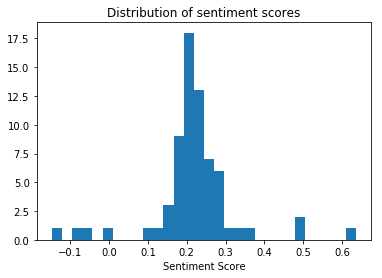

In [75]:
plt.title('Distribution of sentiment scores')
plt.xlabel('Sentiment Score')
plt.hist(sentiment_df['sentiment_score'].dropna(), bins = 30);


## Recommendations

### Show the best dishes

In [76]:
sentiment_df.nlargest(10, 'sentiment_score')


,food_id,sentiment_score,stars_pred,mentions
15,plats_du_jour,0.636900,5.0,1
65,gluten_free_toast,0.503800,5.0,7
54,avocado_toast,0.484000,4.5,3
70,chocolate_mousse,0.360858,3.0,80
9,spicy_salmon_tartare,0.346709,3.0,33
47,macaroni_gratin,0.306911,2.5,64
6,chicken_liver_mousse_pate,0.291230,2.5,114
4,duck_confit,0.283373,2.5,76
3,baked_goat_cheese,0.280490,2.5,324
57,cubano,0.278860,2.0,15


Looks like dishes with few mentions have an unfair advantage. Let's try ranking foods with more than few mentions. Note that the stars prediction is oversimplified and can be designed/tweaked. 

In [126]:
sentiment_df[sentiment_df['mentions'] >= 10].nlargest(10, ['sentiment_score'])

,food_id,sentiment_score,stars_pred,mentions
70,chocolate_mousse,0.360858,3.0,80
9,spicy_salmon_tartare,0.346709,3.0,33
47,macaroni_gratin,0.306911,2.5,64
6,chicken_liver_mousse_pate,0.291230,2.5,114
4,duck_confit,0.283373,2.5,76
3,baked_goat_cheese,0.280490,2.5,324
57,cubano,0.278860,2.0,15
50,classic_eggs_benedict,0.273474,2.0,538
0,onion_soup_au_gratin,0.271198,2.0,987
73,gala_apple_tarte_tatin,0.268800,2.0,17


Dishes that are rarely mentioned 

In [127]:
sentiment_df[sentiment_df['mentions'] <= 10].nsmallest(10, ['mentions'])

,food_id,sentiment_score,stars_pred,mentions
20,root_vegetable_salad,NaN,1.0,0
33,tournedos_of_beef,NaN,1.0,0
46,sauteed_mushrooms,NaN,1.0,0
51,artichoke_and_spinach_benedict,NaN,1.0,0
52,salmon_and_hash_brown_benedict,NaN,1.0,0
66,applewood_smoked_bacon,NaN,1.0,0
67,sauteed_trout,NaN,1.0,0
15,plats_du_jour,0.6369,5.0,1
16,poisson_du_jour,0.0000,1.0,2
38,casareccia_pasta,-0.1480,1.0,2


### Show the worst dishes

In [79]:
sentiment_df.nsmallest(10, ['stars_pred', 'mentions'])

,food_id,sentiment_score,stars_pred,mentions
20,root_vegetable_salad,NaN,1.0,0
33,tournedos_of_beef,NaN,1.0,0
46,sauteed_mushrooms,NaN,1.0,0
51,artichoke_and_spinach_benedict,NaN,1.0,0
52,salmon_and_hash_brown_benedict,NaN,1.0,0
66,applewood_smoked_bacon,NaN,1.0,0
67,sauteed_trout,NaN,1.0,0
16,poisson_du_jour,0.00000,1.0,2
38,casareccia_pasta,-0.14800,1.0,2
59,banana_foster_waffle,-0.08808,1.0,5


Now only using dishes with more than 100 mentions:

In [80]:
sentiment_df[sentiment_df['mentions'] >= 100].nsmallest(10, ['stars_pred', 'mentions'])

,food_id,sentiment_score,stars_pred,mentions
74,maple_bread_pudding,0.209417,1.5,111
8,chilled_seafood_platter,0.235148,1.5,118
71,vanilla_bean_creme_brulee,0.198299,1.0,127
56,prime_steak_sandwich,0.187556,1.0,139
58,waffle,0.178049,1.0,139
61,seafood_crepe,0.229868,1.5,139
29,hanger_steak,0.233625,1.5,147
68,hash_browns,0.228410,1.5,152
48,omelette,0.211049,1.5,162
22,au_poivre,0.161159,1.0,166


In [81]:
sentiment_df.to_csv('../data/predictions/sentiment_df.csv')

### Predictions after dropping `compound=0`
I am treating chunks with `compound=0` as reviews with no opinion.

In [82]:
food_sentiments2 = {}

for food_id, chunks in food_chunks2.items():
    # Run sentiment analyzer if item has chunks, otherwise default to 0
    if len(chunks) > 0:
        sentiment_score = get_sentiments(chunks)['compound']
        food_sentiments2[food_id] = sentiment_score[sentiment_score != 0].mean()
    else:
        food_sentiments2[food_id] = np.nan

In [83]:
sentiment_df2 = pd.DataFrame(list(zip(food_sentiments2.keys(), food_sentiments2.values())), columns = ['food_id', 'sentiment_score'])


In [84]:
sentiment_df2['stars_pred'] = sentiment_df2['sentiment_score'].apply(lambda score : transform_to_stars(score))
sentiment_df2['mentions'] = sentiment_df2['food_id'].apply(lambda food_id : len(food_chunks[food_id]))

In [111]:
sentiment_df2.to_csv('../data/predictions/sentiment_df_subjective.csv')

#### With custom transformations

In [112]:
sentiment_df3 = pd.DataFrame(list(zip(food_sentiments2.keys(), food_sentiments2.values())), columns = ['food_id', 'sentiment_score'])

sentiment_df3['stars_pred'] = sentiment_df3['sentiment_score'].apply(lambda score : transform_to_stars(score))
sentiment_df3['mentions'] = sentiment_df3['food_id'].apply(lambda food_id : len(food_chunks[food_id]))

Best dishes with over 200 mentions

In [113]:
sentiment_df3[sentiment_df3['mentions'] > 200].sort_values(by = ['stars_pred', 'mentions'], ascending = [False, False])


,food_id,sentiment_score,stars_pred,mentions
36,salmon,0.473217,4.5,873
50,classic_eggs_benedict,0.473387,4.5,538
0,onion_soup_au_gratin,0.426657,4.0,987
12,scallops_gratinees,0.421878,4.0,637
30,filet_mignon,0.433164,4.0,550
53,french_toast,0.459178,4.0,360
3,baked_goat_cheese,0.455625,4.0,324
63,quiche,0.451370,4.0,293
26,prime_steak_frites,0.395956,3.5,532
13,mussels_mariniere,0.388301,3.5,435


In [87]:
sentiment_df3[sentiment_df3['food_id'] == 'onion_soup_au_gratin']

,food_id,sentiment_score,stars_pred,mentions
0,onion_soup_au_gratin,0.426657,4.0,987


Worst dishes with over 200 mentions

In [89]:
sentiment_df3[sentiment_df3['mentions'] < 10].dropna().sort_values(by = ['stars_pred', 'mentions'], ascending = [False, False])


,food_id,sentiment_score,stars_pred,mentions
65,gluten_free_toast,0.587767,5.0,7
15,plats_du_jour,0.636900,5.0,1
54,avocado_toast,0.484000,4.5,3
1,steamed_artichoke,0.404060,3.5,8
14,gabis_fish_and_frites,-0.381800,1.0,7
59,banana_foster_waffle,-0.440400,1.0,5
38,casareccia_pasta,-0.296000,1.0,2


### Distribution of sentiment scores

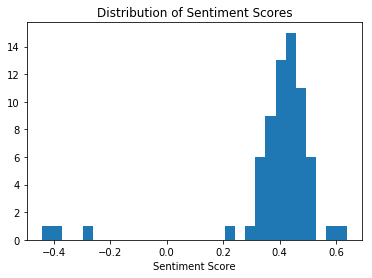

In [90]:
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.hist(sentiment_df2['sentiment_score'].dropna(), bins = 30);

### Show the best dishes

In [91]:
sentiment_df2.nlargest(10, ['stars_pred', 'mentions'])


,food_id,sentiment_score,stars_pred,mentions
36,salmon,0.473217,4.5,873
50,classic_eggs_benedict,0.473387,4.5,538
2,smoked_salmon,0.475773,4.5,181
35,trout_almondine,0.497268,4.5,173
29,hanger_steak,0.464093,4.5,147
61,seafood_crepe,0.463020,4.5,139
21,classique,0.497640,4.5,122
6,chicken_liver_mousse_pate,0.478449,4.5,114
70,chocolate_mousse,0.497734,4.5,80
40,pommes_puree,0.498181,4.5,53


Using dishes with more than 100 reviews:

In [92]:
sentiment_df2[sentiment_df2['mentions'] >= 100].nlargest(10, ['stars_pred', 'mentions'])

,food_id,sentiment_score,stars_pred,mentions
0,onion_soup_au_gratin,0.426657,4.0,987
36,salmon,0.473217,4.5,873
12,scallops_gratinees,0.421878,4.0,637
30,filet_mignon,0.433164,4.0,550
50,classic_eggs_benedict,0.473387,4.5,538
53,french_toast,0.459178,4.0,360
3,baked_goat_cheese,0.455625,4.0,324
63,quiche,0.451370,4.0,293
2,smoked_salmon,0.475773,4.5,181
35,trout_almondine,0.497268,4.5,173


### Show the worst dishes

In [94]:
sentiment_df2.nsmallest(10, 'sentiment_score')

,food_id,sentiment_score,stars_pred,mentions
59,banana_foster_waffle,-0.440400,1.0,5
14,gabis_fish_and_frites,-0.381800,1.0,7
38,casareccia_pasta,-0.296000,1.0,2
10,oysters_du_jour,0.208883,1.5,10
43,brussels_sprouts,0.305337,2.5,62
69,housemade_english_muffin,0.332280,3.0,48
71,vanilla_bean_creme_brulee,0.333041,3.0,127
37,classic_skate_wing,0.337419,3.0,56
5,country_pate,0.339022,3.0,56
44,french_green_beans,0.342860,3.0,79


## Conclusion

### Answers:
1. What are the best dishes to order at Mon Ami Gabi?  
****
2. What are the worst dishes?  
****
3. What are the popular dishes?  
****
4. What are the least popular dishes?  
****